### Description of Project

Company XYZ started a subscription model in January, 2015. You get hired as a first data scientist at the end of August and, as a first task, you are asked to help executives understand how the subscription model is doing.

Therefore, you decide to pull data from all the users who subscribed in January and see, for each month, how many of them unsubscribed.
In particular, your boss is interested in:

* A model that predicts monthly retention rate for the different subscription price points
* Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?
* How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'figure.figsize':(6, 4), 'legend.loc':'right'})

### 1. Read Data

In [2]:
data = pd.read_csv("../dataset/subscription.csv")

### 2. Data Exploration Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   user_id                    500000 non-null  int64 
 1   subscription_signup_date   500000 non-null  object
 2   subscription_monthly_cost  500000 non-null  int64 
 3   country                    500000 non-null  object
 4   source                     500000 non-null  object
 5   billing_cycles             500000 non-null  int64 
 6   is_active                  500000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 26.7+ MB


In [4]:
data["signup_date"] = pd.to_datetime(data.subscription_signup_date).dt.date
data["monthly_cost"] = data["subscription_monthly_cost"]
data = data.drop(["subscription_signup_date", "subscription_monthly_cost"], axis=1)
data.describe(include="all")

,user_id,country,source,billing_cycles,is_active,signup_date,monthly_cost
count,500000.000000,500000,500000,500000.000000,500000.000000,500000,500000.000000
unique,NaN,8,3,NaN,NaN,1,NaN
top,NaN,US,ads,NaN,NaN,2015-01-01,NaN
freq,NaN,91731,414469,NaN,NaN,500000,NaN
mean,250000.500000,NaN,NaN,2.384970,0.099998,NaN,48.469620
std,144337.711634,NaN,NaN,2.254952,0.299998,NaN,19.570745
min,1.000000,NaN,NaN,1.000000,0.000000,NaN,29.000000
25%,125000.750000,NaN,NaN,1.000000,0.000000,NaN,29.000000
50%,250000.500000,NaN,NaN,1.000000,0.000000,NaN,49.000000
75%,375000.250000,NaN,NaN,3.000000,0.000000,NaN,49.000000


### 3. Tasks 
#### Part 1. Build a model that predicts monthly retention rate for the different subscription price points

In [5]:
data.head()

,user_id,country,source,billing_cycles,is_active,signup_date,monthly_cost
0,1459,Spain,ads,4,0,2015-01-01,29
1,12474,France,ads,5,0,2015-01-01,49
2,12294,Germany,ads,2,0,2015-01-01,49
3,3878,China,ads,1,0,2015-01-01,49
4,9567,UK,ads,5,0,2015-01-01,49


In [6]:
bc_cnts = data.groupby("monthly_cost").apply(lambda df: df.groupby("billing_cycles").size()).T
bc_cnts.columns.name = None
bc_cnts

,29,49,99
billing_cycles,,,
1,57441,185145,44788
2,21818,53296,4724
3,12037,21690,1471
4,7787,11288,678
5,5505,6727,399
6,4136,4405,226
7,3111,3173,156
8,34527,14673,799


Above is the number of subscribtions in each billing cycle, once a subscriber enters the n+1 billing cycle, it exits the nth billing cycle. So I should do a reverse cumsum to build the billing cycle subscriber funnel.

<IPython.core.display.Javascript object>


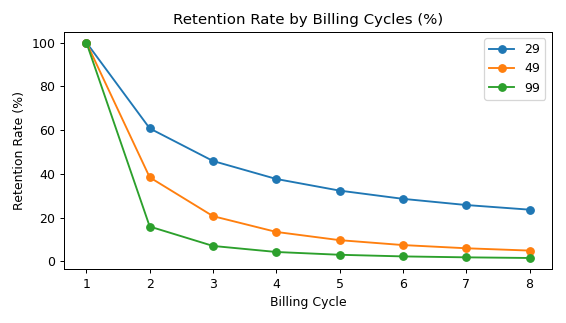

In [10]:
%matplotlib notebook
subscriber_funnel = bc_cnts.apply(lambda s: s[::-1].cumsum()[::-1])
_ = subscriber_funnel.apply(lambda s: (s/s.max()*100)).plot(style="o-", figsize=(7,4))
_ = plt.ylabel("Retention Rate (%)")
_ = plt.xlabel("Billing Cycle")
_ = plt.title("Retention Rate by Billing Cycles (%)")

#### Part 2. Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

<IPython.core.display.Javascript object>


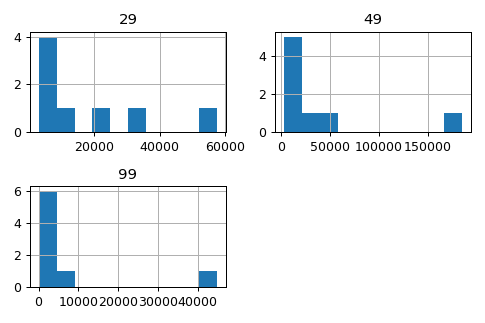

In [11]:
# plot the histograms of the # subscribers from each billing cycle
_ = bc_cnts.hist()

The retention rate on the 12th billing cycle can be obtained from the predicted # subscribers on the 12th billing cycle. The predictive model here is a multiple linear regression with features that model the nonlinearity relationship between billing cycles and # subscribers.

* In the histogram above, I find the number of subscribers from different billing cycles form long-tail distributions. Thus, I will use log(# subscribers) as the dependent variable (y), and then exponentiate the prediction result for the 12th billing cycle retention rate calculation. 

* For the predictor variables I will use a t, t^2, t^3 and log(t).

In [12]:
def create_polynomial_variables(t):
    return pd.DataFrame({"t":t, "t^2": t**2, "t^3": t**3, "log(t)":np.log(t)})

def polynomial_regression_fitting_prediction(s):
    X = create_polynomial_variables(s.index)
    newX_values = range(1,13)
    newX = create_polynomial_variables(pd.Series(newX_values, index=newX_values))
    prm = LinearRegression()
    predicted_newY = np.exp(prm.fit(X, np.log(s)).predict(newX))
    return pd.Series(predicted_newY, index=newX_values)

In [13]:
predictions = subscriber_funnel.apply(lambda s: polynomial_regression_fitting_prediction(s))
predictions.columns = ["predicted_{}".format(col) for col in predictions.columns]

<IPython.core.display.Javascript object>


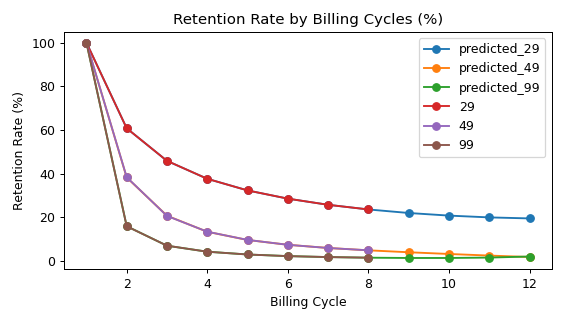

In [14]:
ax = predictions.apply(lambda s: (s/s.max()*100)).plot(style="o-", figsize=(7,4))
_ = subscriber_funnel.apply(lambda s: (s/s.max()*100)).plot(style="o-", ax=ax)
_ = plt.ylabel("Retention Rate (%)")
_ = plt.xlabel("Billing Cycle")
_ = plt.title("Retention Rate by Billing Cycles (%)")

In [15]:
predictions.apply(lambda s: (s/s.max()*100)).loc[12,:].map(lambda x: "{:.2f}%".format(x))

predicted_29    19.49%
predicted_49     1.81%
predicted_99     2.04%
Name: 12, dtype: object

The regression extrapolations indicate 
* a retention rate of 19.49% on monthly cost of 29 dollars; 
* a retention rate of 1.81% on monthly cost of 49 dollars;
* a retention rate of 2.04% on monthly cost of 99 dollars. 

#### Part 3. How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

In [16]:
def retention_analysis_by_segement(segment):
    
    segment_retentions = data.groupby(segment)\
    .apply(lambda df: df.groupby("billing_cycles").size()).T\
    .apply(lambda s: s[::-1].cumsum()[::-1])\
    .apply(lambda s: s/s.max()*100)
    _ = segment_retentions.plot(style="o-",figsize=(8,5))
    _ = plt.ylabel("Retention Rate (%)")
    _ = plt.xlabel("Billing Cycle")
    _ = plt.title("Retention Rate by Billing Cycles (%)")

    print("=> Segment name: {}".format(segment.upper()))
    
    rtr = list(segment_retentions.iloc[-1, :].to_dict().items())
    rtr.sort(reverse=True, key=lambda x: x[1])
    
    for k, v in rtr:
        print("Retention Rate on segment {0}: {1:.2f}%".format(k.upper(), v))

In [17]:
def retention_analysis_by_segement_monthlycost(segment, monthly_cost):

    subscribers = data[data.monthly_cost==monthly_cost].groupby(segment)\
    .apply(lambda df: df.groupby("billing_cycles").size()).T
    
    segment_retentions = subscribers.apply(lambda s: s[::-1].cumsum()[::-1])\
    .apply(lambda s: s/s.max()*100).round(2)\
    .sort_values(8, ascending=False, axis=1)
    
    first_m = subscribers.apply(lambda s: s[::-1].cumsum()[::-1])\
        .sum().sort_values(ascending=False)*monthly_cost
    second_m = subscribers.sum()
    subscribers_8monthRevenues = pd.concat([second_m, first_m], axis=1)
    subscribers_8monthRevenues.columns = ["Jan_TotalSubs_Cnt", "8_month_revenue"]
    
    return segment_retentions, subscribers_8monthRevenues.sort_values("8_month_revenue",
                                                                     ascending=False)

<IPython.core.display.Javascript object>


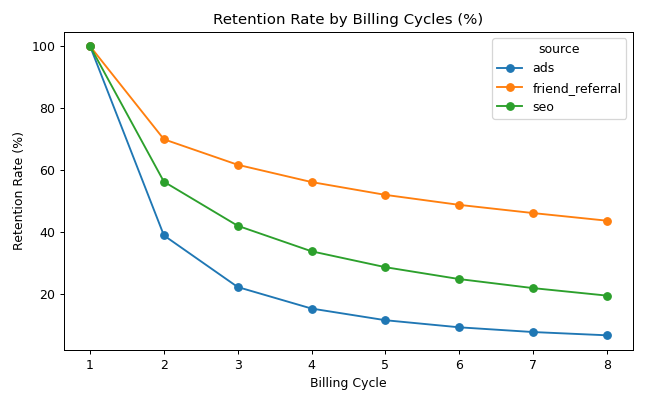

=> Segment name: SOURCE
Retention Rate on segment FRIEND_REFERRAL: 43.65%
Retention Rate on segment SEO: 19.45%
Retention Rate on segment ADS: 6.62%


In [18]:
retention_analysis_by_segement("source")

In [19]:
segment_retentions, first_m = retention_analysis_by_segement_monthlycost("source", 29)
print(first_m)
segment_retentions

                 Jan_TotalSubs_Cnt  8_month_revenue
ads                         121246         11452999
seo                          18019          2390325
friend_referral               7097          1198106


source,friend_referral,seo,ads
billing_cycles,,,
1,100.00,100.00,100.00
2,79.09,70.30,58.26
3,73.79,60.14,42.09
4,70.38,53.42,33.36
5,67.72,48.63,27.80
6,65.55,44.69,23.98
7,63.77,41.55,21.14
8,61.83,38.71,19.10


In [20]:
segment_retentions, first_m = retention_analysis_by_segement_monthlycost("source", 49)
print(first_m)
segment_retentions

                 Jan_TotalSubs_Cnt  8_month_revenue
ads                         249177         20948774
seo                          36631          5200615
friend_referral              14589          3329942


source,friend_referral,seo,ads
billing_cycles,,,
1,100.00,100.00,100.00
2,70.89,54.70,34.06
3,61.50,37.89,15.69
4,54.88,28.30,8.79
5,49.83,22.52,5.40
6,45.95,18.38,3.54
7,42.82,15.23,2.42
8,39.95,12.72,1.68


In [21]:
segment_retentions, first_m = retention_analysis_by_segement_monthlycost("source", 99)
print(first_m)
segment_retentions

                 Jan_TotalSubs_Cnt  8_month_revenue
ads                          44046          5301648
seo                           6453          1097019
friend_referral               2742           748737


source,friend_referral,seo,ads
billing_cycles,,,
1,100.00,100.00,100.00
2,41.25,25.72,12.85
3,31.51,14.66,4.36
4,25.89,9.86,2.07
5,22.72,7.44,1.08
6,20.28,5.59,0.60
7,17.91,4.62,0.38
8,16.27,3.83,0.24


It is found across different pricing categories friend_referral is the best marketing tactics when talking about retention rate. However, ads brings in the most revenue by subscription fee in the last months, across the 3 pricing categories (because of the larger scale of reach of potential subscribers). 

As a result, we should increase the reach of the referral tactics and incentivize our existing subscribers to refer our service to their friends. For example, we can give credits as a reward of a new subscriber's first subscription after the referral from an old subscriber.

<IPython.core.display.Javascript object>


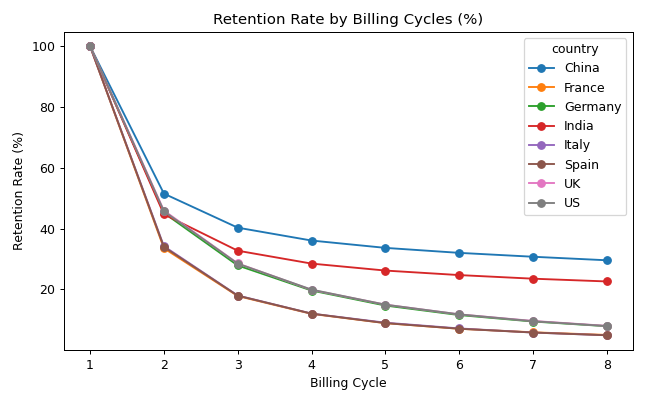

=> Segment name: COUNTRY
Retention Rate on segment CHINA: 29.55%
Retention Rate on segment INDIA: 22.58%
Retention Rate on segment UK: 7.95%
Retention Rate on segment US: 7.90%
Retention Rate on segment GERMANY: 7.85%
Retention Rate on segment FRANCE: 4.97%
Retention Rate on segment ITALY: 4.87%
Retention Rate on segment SPAIN: 4.85%


In [22]:
retention_analysis_by_segement("country")

China and India has the highest retention rate when pooling the (29, 49, 99) USD subscribers together. UK and US follows behind, and the 4 European countires show lowest overall retention rate. 

In below, I will break the subscribers into 3 groups (29, 49, 99) and recalculate retention rates. 

In [23]:
segment_retentions, first_m = retention_analysis_by_segement_monthlycost("country", 29)
print(first_m)
segment_retentions

         Jan_TotalSubs_Cnt  8_month_revenue
India                16920          2835968
China                16741          2816944
UK                   25181          2107314
US                   25416          2103196
Germany              21794          1810151
France               14249          1199295
Italy                13336          1106553
Spain                12725          1062009


country,China,India,France,Germany,Spain,UK,Italy,US
billing_cycles,,,,,,,,
1,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2,79.31,79.26,55.51,54.99,55.10,55.45,55.17,55.11
3,73.74,73.68,37.81,37.16,37.63,37.96,37.34,37.31
4,70.33,70.08,28.09,27.88,28.15,28.02,27.61,27.68
5,67.57,67.19,22.17,21.67,21.98,22.05,21.72,21.53
6,65.12,64.70,18.13,17.56,17.72,17.83,17.58,17.41
7,63.04,62.51,15.29,14.63,14.70,14.84,14.37,14.23
8,61.12,60.56,13.23,12.52,12.51,12.42,12.34,12.09


In [24]:
segment_retentions, first_m = retention_analysis_by_segement_monthlycost("country", 49)
print(first_m)
segment_retentions

         Jan_TotalSubs_Cnt  8_month_revenue
Germany              55500          6385288
US                   55385          6370784
UK                   54966          6306349
France               31074          2414230
Italy                29578          2304323
Spain                27709          2135616
India                27644          2133166
China                18541          1429575


country,Germany,US,UK,Italy,India,France,China,Spain
billing_cycles,,,,,,,,
1,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2,46.60,46.47,46.81,28.44,27.92,28.41,27.82,28.17
3,28.08,28.22,28.06,11.44,11.29,11.57,11.34,11.26
4,19.20,19.16,18.93,6.50,6.33,6.52,6.28,6.24
5,14.08,14.11,13.91,4.45,4.20,4.29,4.11,4.09
6,10.89,10.91,10.70,3.35,3.18,3.15,3.17,3.05
7,8.75,8.73,8.62,2.64,2.47,2.55,2.57,2.47
8,7.19,7.16,7.12,2.17,2.10,2.07,2.06,2.01


In [25]:
segment_retentions, first_m = retention_analysis_by_segement_monthlycost("country", 99)
print(first_m)
segment_retentions

         Jan_TotalSubs_Cnt  8_month_revenue
Germany              11650          1696662
UK                   11105          1602909
US                   10930          1563606
France                6339           736164
Spain                 4553           534204
Italy                 4545           533610
India                 3463           401940
China                  656            78309


country,Germany,UK,US,Spain,France,China,Italy,India
billing_cycles,,,,,,,,
1,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2,19.67,19.68,19.49,9.62,8.96,10.21,9.83,9.44
3,9.28,9.35,8.84,3.14,3.16,4.27,3.43,3.38
4,5.96,5.53,5.43,1.80,1.86,2.13,1.87,1.65
5,4.19,3.95,3.73,1.30,1.25,1.68,1.34,1.01
6,3.18,3.01,2.79,1.12,0.79,0.91,0.88,0.69
7,2.62,2.34,2.32,0.83,0.66,0.76,0.68,0.58
8,2.21,1.95,1.89,0.70,0.63,0.61,0.55,0.49


* China and India has largest retention rate with the 29 USD monthly cost (~60.5%). 
* Germany, US and UK rank top 3 in retention rates with the 49 and 99 USD monthly cost (~7.2%, ~2%). 

The above means China and India customers are quite loyal to the service and they tend to continue subscription under the 29 USD category. We should try harder to introduce the 29 USD service to Chinese and Indian customers, by all marketing tactics (ads, promotions, etc).

The German, US and UK people are more loyal subscribers under the 49 and 99 USD category. However, the retention in the the 99 USD is so low that the 8-month revenue is also smaller than the 49 USD version. Low revenue and low retention rate makes 99 USD category service less profitable in both short and long term. Thus, we need to focus more subscription conversions on 49 USD cateogry service to German, UK, US peple, through marketing tactics.